In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import imageio
import numpy as np
import itertools
import json

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import DenseNet121
from keras.layers import Dense, Input, GlobalAveragePooling2D, AveragePooling2D, Dropout, Flatten
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.utils import multi_gpu_model, to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import cv2
from imutils import paths

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# dataset duplicate sanity check
base_dir = "/content/drive/My Drive/Deep Learning Project/"
test_dir = os.path.join(base_dir, "test")
train_dir = os.path.join(base_dir, "train")
overlaps = {}
for class_name in os.listdir(test_dir):
    train_imgs = os.listdir(os.path.join(train_dir, class_name))
    test_imgs = os.listdir(os.path.join(test_dir, class_name))
    print(class_name, len(train_imgs), len(test_imgs))
    overlaps[class_name] = []
    for i in test_imgs:
        if i in train_imgs:
            overlaps[class_name].append(i)
print("\noverlaps:")
for i in overlaps:
    print(i, len(overlaps[i]))

COVID-19 176 43
NORMAL 176 43
Viral Pneumonia 176 43

overlaps:
COVID-19 0
NORMAL 0
Viral Pneumonia 0


In [ ]:
train_x = []
train_y = []
test_x = []
test_y = []

index = -1
for class_name in os.listdir(test_dir):
  train_imgs = list(paths.list_images(os.path.join(train_dir, class_name)))
  test_imgs = list(paths.list_images(os.path.join(test_dir, class_name)))
  index += 1

  for img in train_imgs:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))

    train_x.append(image)
    train_y.append(index)

  for img in test_imgs:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))

    test_x.append(image)
    test_y.append(index)

#COVID-19 = 0, Normal = 1, Viral Pneumonia = 2
print(len(train_x), len(train_y), train_y[0], train_y[176])

528 528 0 1


In [ ]:
train_x = np.array(train_x) / 255.0
train_y = np.array(train_y)

test_x = np.array(test_x) / 255.0
test_y = np.array(test_y)

train_y = to_categorical(train_y, num_classes = len(os.listdir(test_dir)))
test_y = to_categorical(test_y, num_classes = len(os.listdir(test_dir)))

val_split = 0.3
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = val_split, random_state = 42)

print(len(train_x), len(val_x))

369 159


In [ ]:
# Dataset config
input_shape = (256, 256, 3)
num_classes = 3
input_tensor = Input(shape = input_shape)

batch_size = 10
max_epochs = 100

#Optimizer
initial_lr = 1e-5
min_lr = 1e-6
lr_reduction_patience = 3
lr_change_factor = 0.2
early_stop_patience = 20
opt = Adam(learning_rate = initial_lr)

data_generator = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)

In [ ]:
densenet_model = DenseNet121(include_top = False, input_tensor = input_tensor, weights = "imagenet")

x = densenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(3, activation = 'softmax')(x)

model = Model(inputs = densenet_model.input, outputs = predictions)

for i, layer in enumerate(densenet_model.layers):
    print(i, layer.name)

29089792/29084464 [==============================] - 0s 0us/step
0 input_1
1 zero_padding2d
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_1
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_

In [ ]:
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

H = model.fit(
    data_generator.flow(train_x, train_y, batch_size = batch_size),
    validation_data=(val_x, val_y),
    epochs=max_epochs,
    verbose = 1)

Epoch 1/100
37/37 [==============================] - 9s 252ms/step - loss: 1.0284 - accuracy: 0.5176 - val_loss: 1.2857 - val_accuracy: 0.3270
Epoch 2/100
37/37 [==============================] - 6s 166ms/step - loss: 0.7031 - accuracy: 0.7615 - val_loss: 1.0778 - val_accuracy: 0.4340
Epoch 3/100
37/37 [==============================] - 6s 169ms/step - loss: 0.5511 - accuracy: 0.8401 - val_loss: 0.9095 - val_accuracy: 0.5597
Epoch 4/100
37/37 [==============================] - 6s 167ms/step - loss: 0.4424 - accuracy: 0.8862 - val_loss: 0.7595 - val_accuracy: 0.6792
Epoch 5/100
37/37 [==============================] - 6s 166ms/step - loss: 0.3743 - accuracy: 0.8889 - val_loss: 0.6347 - val_accuracy: 0.7673
Epoch 6/100
37/37 [==============================] - 6s 166ms/step - loss: 0.3479 - accuracy: 0.9024 - val_loss: 0.5094 - val_accuracy: 0.8113
Epoch 7/100
37/37 [==============================] - 6s 168ms/step - loss: 0.2930 - accuracy: 0.9051 - val_loss: 0.4443 - val_accuracy: 0.8491

In [ ]:
preds = model.predict(test_x, batch_size = batch_size)
preds = np.argmax(preds, axis=1)

In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    # set the size of the figure here
    plt.figure(figsize=(15,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=80) # set x-axis text angle here
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[42  0  1]
 [ 0 42  1]
 [ 0  0 43]]
Accuracy:  0.9844961240310077


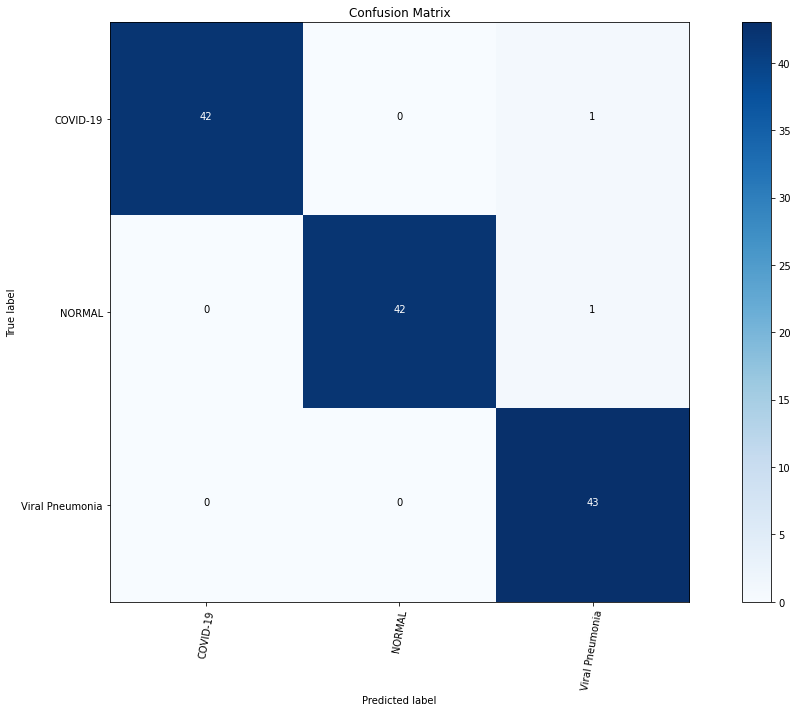

In [ ]:
cm = confusion_matrix(test_y.argmax(axis=1), preds)

cm_plot_labels = os.listdir(test_dir)
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print("Accuracy: ", accuracy)

In [ ]:
report =  classification_report(test_y.argmax(axis=1), preds, target_names=cm_plot_labels)

print(report)

                 precision    recall  f1-score   support

       COVID-19       1.00      0.98      0.99        43
         NORMAL       1.00      0.98      0.99        43
Viral Pneumonia       0.96      1.00      0.98        43

       accuracy                           0.98       129
      macro avg       0.99      0.98      0.98       129
   weighted avg       0.99      0.98      0.98       129



<Figure size 432x288 with 0 Axes>

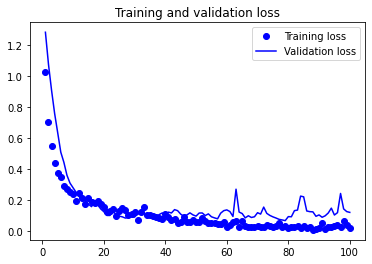

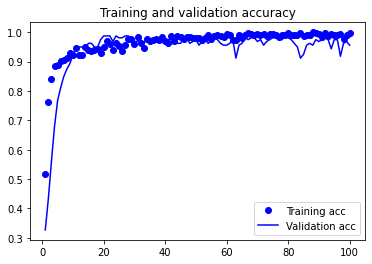

<Figure size 432x288 with 0 Axes>

In [ ]:
# display the loss and accuracy curves

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()